In [1]:
import os
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision.transforms as transforms
from accelerate import Accelerator
# from cond_sky_dataset import SkyDataset
# from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, DiffusionPipeline, ImagePipelineOutput, UNet2DModel
from matplotlib.ticker import MaxNLocator
from metrics import apply_mask, average_deviation, compute_batch_mse, compute_batch_psnr, compute_batch_ssim
from PIL import Image, ImageSequence

from torch_utils import randn_tensor
from video_datasets import load_data

In [ ]:
MODEL_PATH = "conditional_ddpm.pt"

In [2]:
class DDPMPipeline(DiffusionPipeline):
    model_cpu_offload_seq = "unet"
    def __init__(self, unet, scheduler):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)

    @torch.no_grad()
    def __call__(
        self,
        conditioning,
        batch_size: int = 10,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                3,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, 3, *self.unet.config.sample_size)

        if self.device.type == "mps":
            # randn does not work reproducibly on mps
            image = randn_tensor(image_shape, generator=generator)
            image = image.to(self.device)
        else:
            image = randn_tensor(image_shape, generator=generator, device=self.device)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            cond_with_image = torch.cat([conditioning, image], axis=1)
            
            model_output = self.unet(cond_with_image, t).sample

            # 2. compute previous image: x_t -> x_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        return image.cpu()

In [3]:
@dataclass
class TrainingConfig:
    seq_len = 5
    image_size = 128
    batch_size = 5
    
    gradient_accumulation_steps = 1
    mixed_precision = "fp16"
    output_dir = "generated_videos"


config = TrainingConfig()

In [4]:
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3 * config.seq_len,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [5]:
model.load_state_dict(torch.load(MODEL_PATH))
model.to("cuda")

UNet2DModel(
  (conv_in): Conv2d(15, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Co

In [6]:
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    log_with="tensorboard",
    project_dir=os.path.join(config.output_dir, "logs"),
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
ddpm_pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

In [7]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)
# dataset = SkyDataset(transform=preprocess, seq_len=21, offset=1)
# train_dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)
train_dataloader = load_data(
    data_dir="../../data_samples/gif_128",
    batch_size=config.batch_size,
    image_size=128,
    class_cond=False,
    deterministic=True,
    rgb=True,
    seq_len=20
)

In [8]:
original, _ = next(iter(train_dataloader))
original_seq = [torch.squeeze(original.permute(0, 2, 1, 3, 4)[:,i:i+1], dim=1) for i in range(20)]

In [ ]:
original_seq[0].shape

In [10]:
new_seq = original_seq[:4]

In [11]:
transform = transforms.ToTensor()
for i in range(4, 20):
    conditioning = torch.stack(new_seq[-4:], dim=1)
    conditioning = conditioning.view(config.batch_size, 12, config.image_size, config.image_size).to("cuda")
    res = ddpm_pipeline(
        conditioning=conditioning,
        batch_size=config.batch_size
    )
    print(res.shape)
    new_seq.append(res)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 128])


In [12]:
generated_seq = new_seq[:20]

In [13]:
ssims = []
psnrs = []
mses = []
for real, fake in zip(original_seq, generated_seq):
    ssims.append(compute_batch_ssim(real, fake))
    psnrs.append(compute_batch_psnr(real, fake))
    mses.append(compute_batch_mse(real, fake))

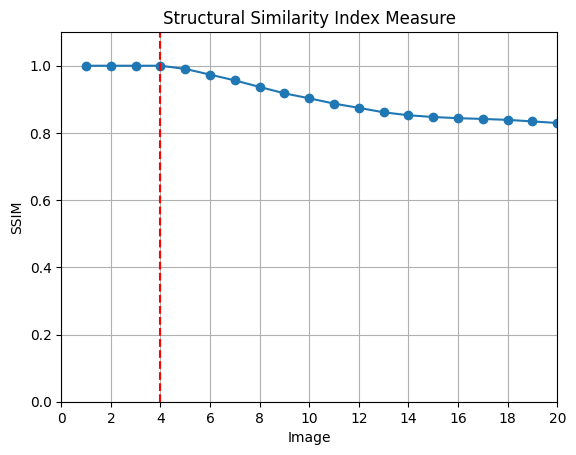

In [14]:
plt.plot(list(range(1, 21, 1)), ssims, marker='o')
plt.axvline(x=4, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Structural Similarity Index Measure')
plt.xlabel('Image')
plt.ylabel('SSIM')
plt.xlim(0, 20)
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()

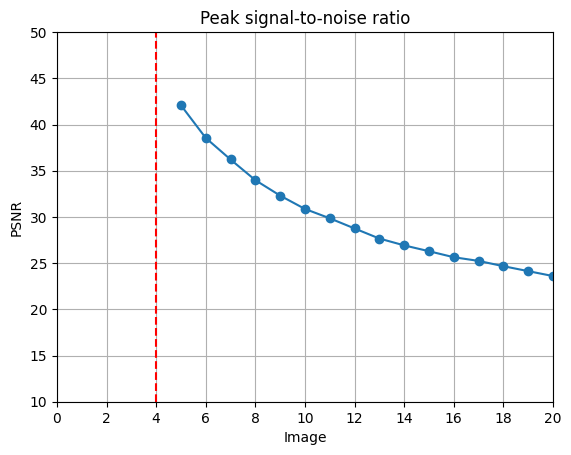

In [15]:
plt.plot(list(range(1, 21, 1)), psnrs, marker='o')
plt.axvline(x=4, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Peak signal-to-noise ratio')
plt.xlabel('Image')
plt.ylabel('PSNR')
plt.xlim(0, 20)
plt.ylim(10, 50)
plt.grid(True)
plt.show()

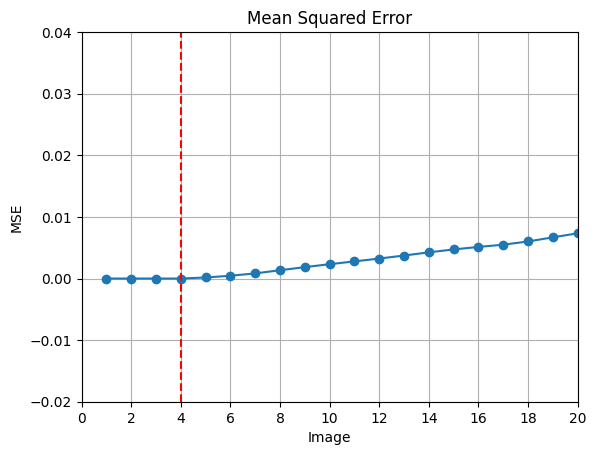

In [16]:
plt.plot(list(range(1, 21, 1)), mses, marker='o')
plt.axvline(x=4, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Mean Squared Error')
plt.xlabel('Image')
plt.ylabel('MSE')
plt.xlim(0, 20)
plt.ylim(-0.02, 0.04)
plt.grid(True)
plt.show()

In [17]:
def create_gif(arr, gif_path, duration=100, size=64):
    image_list = [Image.fromarray(np.uint8(myarray*255)) for myarray in arr]

    image_list[0].save(
            gif_path,
            save_all=True,
            append_images=image_list[1:], # append rest of the images
            duration=100, # in milliseconds
            loop=1)

In [18]:
os.makedirs(config.output_dir, exist_ok=True)
for i in range(config.batch_size):
    im_list = [original_seq[j][i] for j in range(20)]
    imgs = ((torch.stack(im_list) + 1) / 2).permute(0, 2, 3, 1).cpu().numpy()
    create_gif(imgs, f"{config.output_dir}/{i}.gif")

In [20]:
def separate_gif_frames(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".gif"):
            gif_path = os.path.join(input_dir, filename)
            gif = Image.open(gif_path)
            frames = [frame.copy() for frame in ImageSequence.Iterator(gif)]
            for i, frame in enumerate(frames):
                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{i+1}.png")
                frame.save(output_path, format="PNG")

separate_gif_frames(config.output_dir, "separated_images")

In [21]:
to_pil = transforms.ToPILImage()
cov_mses = []
for real, fake in zip(original_seq, generated_seq):
    real_mask = apply_mask((real * 255))
    fake_mask = apply_mask((fake * 255))
    cov_mses.append([((i - j)**2).mean().item()*100 for i, j in zip(fake_mask, real_mask)])

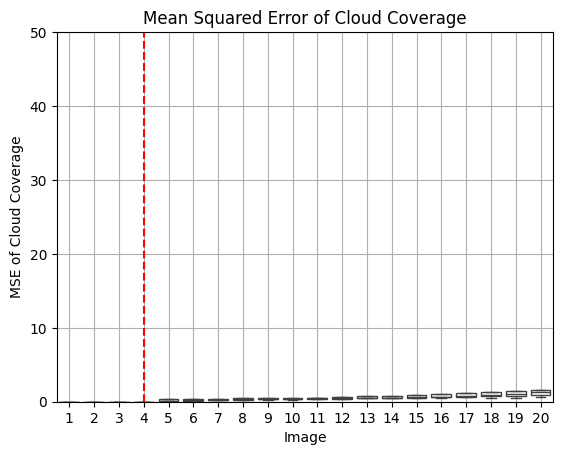

In [22]:
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')

sns.boxplot(data=cov_mses, showfliers=False, color='white')
plt.axvline(x=3, color='r', linestyle='--')
plt.ylim(0, 50)
plt.xticks(ticks=range(len(cov_mses)), labels=[i+1 for i in range(len(cov_mses))])
plt.grid(True)
plt.title('Mean Squared Error of Cloud Coverage')
plt.xlabel('Image')
plt.ylabel('MSE of Cloud Coverage')
plt.show()

In [ ]:
average_deviation(cov_mses[11])

In [ ]:
average_deviation(cov_mses[-1])